In [13]:
from matplotlib import pyplot as plt
import numpy as np
from math import sqrt, log, exp
from statistics import NormalDist
import copy
import pandas as pd
from itertools import islice
import statistics
from models import BlackScholes as bs, GeometricBrownianMotion as gbm, StockPosition as sp
from models.deltahedge import DeltaHedge as dh, DeltaHedgeSim as dhs

Starting Cost: $3546.03
-------- STOCK DETAILS --------
Starting Price: $100.00
Final Price: $98.66
Total Cashflow: $-72.08
------- OPTION DETAILS --------
Start Price: $1.05
Final Price: $0.00
Premium Received: $104.52
Option Payout: $104.52
-------- PROFIT / LOSS --------
P/L: $32.44
Return on Cost: 0.91%
    Years to Maturity  Call Price  Stock Price  Short Call Delta  Stock Delta  \
0            0.050000    1.045209   100.000000        -35.460286    35.460286   
1            0.045833    0.876817    99.724616        -32.279708    32.279708   
2            0.041667    0.749644    99.557220        -29.813770    29.813770   
3            0.037500    0.547456    99.083181        -24.564297    24.564297   
4            0.033333    0.631348    99.690220        -28.441670    28.441670   
5            0.029167    0.690775   100.178082        -31.785915    31.785915   
6            0.025000    0.184297    98.157858        -12.222181    12.222181   
7            0.020833    0.135572    98.199

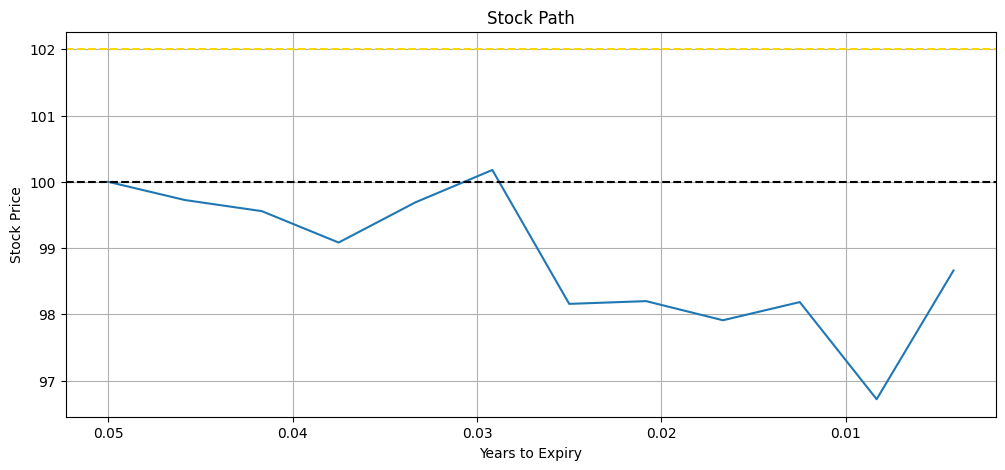

In [20]:
# Set parameters and run the simulation
years = 0.05
sim = dhs.DeltaHedgeSim(100, 102, years, 0.2, 0.0415)
n_steps = int(years * 252)
hedges, stock_path = sim.simulate(n_steps)

def get_pl(hedges):
    total_cashflow = 0
    for h in hedges:
        total_cashflow += h.cash_flow
    
    option_payout = sim.premium_received - (hedges[-1].option.call_price() * 100)
    start_stock_price = hedges[0].option.stock_price
    starting_cost = -hedges[0].cash_flow
    pl = total_cashflow + option_payout
    return pl, starting_cost, option_payout, total_cashflow
# Summarize the results
res = []
for h in hedges:
    res.append(h.display_form())

pl, starting_cost, option_payout, total_cashflow = get_pl(hedges)
# Formats title with hyphens
def formatted_title(title, char='-'):
    star_len = int((30 - len(title)) / 2)
    offset = 0
    if len(title) % 2 == 0:
        offset = -1
    l_len = star_len + offset
    return f"{char * l_len} {title} {char * star_len}"
# Output P/L summary
print(f"Starting Cost: ${starting_cost:.2f}")
print(formatted_title("STOCK DETAILS"))
print(f"Starting Price: ${hedges[0].option.stock_price:.2f}")
print(f"Final Price: ${hedges[-1].option.stock_price:.2f}")
print(f"Total Cashflow: ${total_cashflow:.2f}")
print(formatted_title("OPTION DETAILS"))
print(f"Start Price: ${hedges[0].option.call_price():.2f}")
print(f"Final Price: ${hedges[-1].option.call_price():.2f}")
print(f"Premium Received: ${sim.premium_received:.2f}")
print(f"Option Payout: ${option_payout:.2f}")
print(formatted_title("PROFIT / LOSS"))
print(f"P/L: ${pl:.2f}")
print(f"Return on Cost: {pl / starting_cost*100:.2f}%")


# Display results
df = pd.DataFrame(res)
df = df.head(20)
print(df)
df.style.hide(axis='index')

# Display simulated path
plt.figure(figsize=(12, 5))
plt.title("Stock Path")
plt.plot(stock_path.keys(), stock_path.values())
plt.gca().invert_xaxis()
plt.grid(True)
plt.xlabel("Years to Expiry")
plt.ylabel("Stock Price")
plt.axhline(sim.option.stock_price, color='k', linestyle='--')
plt.axhline(sim.option.strike, color='gold', linestyle='--')



Sim 20000/20000
Simulation Complete.
----------- RESULTS -----------
Starting Cost: $3546.03
Average P/L: $14.05 (0.40%)
Annualized P/L: $281.07 (7.93%)
Time to Expiry: 0.05 years / 18 days
Amount of Rehedges: 12


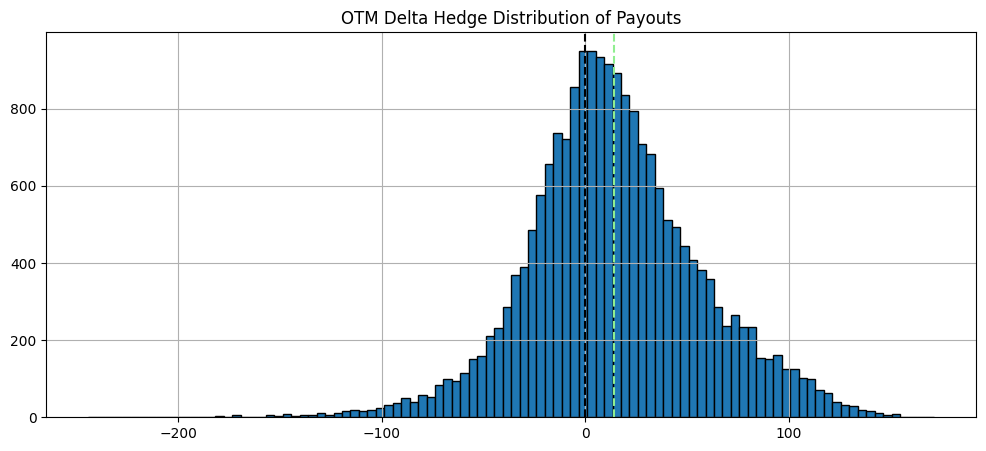

In [ ]:

pls = []
starting_cost = 0
n_sims = 20000
for i in range(n_sims + 1):
    if i % 2000 == 0:
        print(f"\rSim {i}/{n_sims}", end='')
    hedges, stock_path = sim.simulate(n_steps)
    pl, starting_cost, option_payout, total_cashflow = get_pl(hedges)
    pls.append(pl)
print("\nSimulation Complete.")
pls = np.array(pls)
average_pl = np.mean(pls)
print(formatted_title("RESULTS"))
print(f"Starting Cost: ${starting_cost:.2f}")
pl_perc = average_pl / starting_cost * 100
print(f"Average P/L: ${average_pl:.2f} ({pl_perc:.2f}%)")
multiplier = 1 / sim.option.years
annual_pl = average_pl * multiplier
annual_pl_perc = pl_perc * multiplier
print(f"Annualized P/L: ${annual_pl:.2f} ({annual_pl_perc:.2f}%)")
print(f"Time to Expiry: {sim.option.years} years / {int(sim.option.years * 365)} days")
print(f"Amount of Rehedges: {len(hedges)-1}")
plt.figure(figsize=(12, 5))
plt.title("OTM Delta Hedge Distribution of Payouts")
plt.hist(pls, bins=50, edgecolor='k')
pl_color = "lightgreen" if average_pl > 0 else "red"
plt.axvline(average_pl, color=pl_color, linestyle='--')
plt.axvline(0, color='k', linestyle='--')
plt.grid(True)
